In [4]:
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem.snowball import ItalianStemmer
from collections import Counter
from wordcloud import WordCloud
import nltk
from IPython.display import Image 
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download("stopwords") # nltk needs us to manually download the set of stopwords

def get_file_tokens(filename):
    tokens = []
    for line in filename:
        tokens += re.split('\W+', line,  flags=re.UNICODE) # re library deals with the splitting
    return tokens

def generate_tag_cloud(freq, image_filename=None):
	wc = WordCloud(background_color="white").generate_from_frequencies(freq)
	if image_filename:
        # If you pass it a filename, then it saves the image on the provided path
		image = wc.to_image()
		image.save(image_filename)
	else:
        # then it just displays it here on the notebook
		plt.imshow(wc, interpolation='bilinear')
		plt.axis("off")
		plt.show()
        
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('italian'))

def filter_words(words):
    return [w for w in words if len(w)>=3 and w not in STOPWORDS]

def normalize_words(words):
    return [unidecode(w.lower()) for w in words]

def stem_words(words):
	s = ItalianStemmer()
	return [s.stem(w) for w in words]

def get_stem_mapping(words):
	s = ItalianStemmer() 
	mapping = {} # here is our mapping
	for w in words: 
		stemmed_w = s.stem(w)
		if stemmed_w not in mapping: 
			mapping[stemmed_w] = Counter()
		mapping[stemmed_w].update([w])

	return mapping

def destem_words(stems, stem_mapping):
	return [stem_mapping[s].most_common(1)[0][0] for s in stems] # ask the counter to get the most common occurrence for each root word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import os
import pandas as pd

def leggi_file_csv_in_sottocartelle(directory):
    # Lista dei DataFrame letti dai file CSV
    elenco_dataframe = []

    # Naviga attraverso tutte le sottocartelle e file nella directory data
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                # Costruisci il percorso completo del file
                file_path = os.path.join(root, file)
                # Leggi il file CSV e aggiungi il DataFrame alla lista
                df = pd.read_csv(file_path)
                elenco_dataframe.append(df)

    # Concatena tutti i DataFrame in un unico DataFrame
    dataframe_completo = pd.concat(elenco_dataframe, ignore_index=True)
    
    return dataframe_completo

# Specifica la directory radice in cui cercare i file CSV
directory_radice = 'C:/Users/RConti/PycharmProjects/pythonProject/PROGETTONE/CityNews_SCraper'

# Chiama la funzione per leggere e concatenare i file CSV nelle sottocartelle
tutti_i_dati = leggi_file_csv_in_sottocartelle(directory_radice)

In [6]:
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout
import warnings
warnings.filterwarnings("ignore")

# Sample DataFrame with longer category names
df = tutti_i_dati

# Dropdown options (list of Territorio)
dropdown_options = sorted(df['Edizione'].unique().tolist())

# Function to update chart1 based on selected category
def update_chart1(Edizione):
    filtered_df = df[df['Edizione'] == Edizione]

    Testo = filtered_df['Testo'].to_list()
    tokens = get_file_tokens(Testo)
    filtered_t = filter_words(normalize_words(tokens))
    stemmed = stem_words(filtered_t)
    stem_mapping = get_stem_mapping(filtered_t)
    destemmed = destem_words(stemmed, stem_mapping)
    c = Counter(destemmed)

    generate_tag_cloud(c)

    '''y = [count for tag, count in c.most_common(20)]
    x = [tag for tag, count in c.most_common(20)]
    
    plt.barh(x, y)
    plt.gca().invert_yaxis()
    plt.show()'''

    c_df = pd.DataFrame(list(c.items()), columns=['Word', 'Count'])

    # Sort the DataFrame by the 'Count' column in descending order
    df_sorted = c_df.sort_values(by='Count', ascending=False)

    # Select the top 20 rows
    top_20 = df_sorted.head(20)

    chart = alt.Chart(top_20).mark_bar().encode(
        x = 'Count:Q',
        y = alt.Y('Word:N', title='Word', sort='-x'),
        size=alt.Size(field='Count', type='quantitative', bin=alt.BinParams(maxbins=5)),
        color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
        tooltip=['Word', 'Count']
    )
    
    display(chart)

    '''nltk_text = nltk.Text(tokens)
    nltk_text.dispersion_plot(top_20['Word'].to_list())'''

dropdown_edizione = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],  # Set initial value
    description='Select Edizione:',
    style={'description_width': 'initial'}  # Set description width to full
)  

# Initial display of charts and dropdowns side by side
output1 = widgets.Output()

with output1:
    display(VBox([dropdown_edizione]))
    update_chart1(dropdown_edizione.value)

# Arrange the outputs (charts) horizontally using HBox layout
display(output1)

# Set up event handlers for dropdowns
def on_edizione_change(change):
    with output1:
        clear_output(wait=True)
        display(VBox([dropdown_edizione]))
        update_chart1(change.new)

dropdown_edizione.observe(on_edizione_change, names='value')

Output()

#### TagMe

In [7]:
import requests # For REST calls
import json # for modelling objects in the JSON format

# This line opens the file from the file system, the file is in the same folder of the notebook and it is opened in "read-only mode"
with open("config.json", 'r') as json_file:
    config = json.load(json_file) # load the json object inside the config file
    KEY = config['d4science_KEY'] # this is the key we will be using for REST calls

TAGME_ENDPOINT = "https://tagme.d4science.org/tagme/tag"
LANG = "it" # Also works in italian and german

In [8]:
def query_tagme(text, long_text=False):
    payload = {"text": text, "gcube-token": KEY, "lang": LANG}
    if long_text:
        # long_text is by defaul false, but if specified by the user, we set the window size at 5
        payload["long_text"] = 5
    r = requests.post(TAGME_ENDPOINT, payload)
    if r.status_code != 200:
        raise Exception("Error on text: {}\n{}".format(text, r.text))
    return r.json()
    
# Try changing the min_rho parameter and see how it impacts the returned entities
def get_tagme_entities(tagme_response, min_rho=0.001, min_link=0.001):
    ann = tagme_response["annotations"]
    ann = [a for a in ann if a["rho"] > min_rho] # filter all the annotations with a rho score lower than the threshold
    ann = [a for a in ann if a["link_probability"] > min_link] # filter all the annotations with a rho score lower than the threshold
    return [a["title"] for a in ann if "title" in a] # return just the page titles

In [9]:
text = tutti_i_dati['Testo'].to_list()

print("BEFORE FILTERING")
resp = query_tagme(text, long_text=True) 
before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
before_filtering

BEFORE FILTERING


['Agricoltura',
 'Allevamento',
 'Ginocchio',
 'Manifestazione',
 'Sciacca',
 'Mattino',
 'Stato federale',
 'Movimento (sociologia)',
 'Agricoltura',
 'Italiani',
 'Stato federale',
 'Comitato (ordinamento civile italiano)',
 'Associazione (diritto)',
 'Terra e Vita',
 'La vita è',
 "Circolo dell'Unione (Firenze)",
 'La Rinascente',
 'Iniziativa (scacchi)',
 'Necessità',
 'Autorità',
 'Stato della materia',
 'La Grave',
 'Sofferenza',
 'Pressione',
 'Costo',
 'Gestione, amministrazione, esercizio',
 'Produzione',
 'Imposta sul reddito delle persone fisiche',
 'Legge di bilancio',
 'Acqua',
 'Lago Arancio',
 'Inquinamento',
 'Rhodophyta',
 'Corteo storico (Palio di Siena)',
 'Trattore agricolo',
 'Provincia di Siena',
 'Unomattina',
 'Sciacca',
 'Compagnia di Gesù',
 "Direttore d'orchestra",
 'Vettore (matematica)',
 'Menfi',
 'Università degli Studi di Milano',
 'Produzione',
 'Valle del Belice',
 'Sinistra Indipendente',
 'Contestazione',
 'Governo',
 'Renato Schifani',
 'Corrente co

In [11]:
# Lista vuota per memorizzare i risultati della trasformazione
risultati = []

# Ciclo for per iterare attraverso ciascuna lista interna
for i in range(0, len(text)):
    resp = query_tagme(text[i], long_text=True) 
    before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
    risultati.append(before_filtering)

# Visualizzare i risultati
#print(risultati)


In [12]:
# Utilizzare una comprensione di lista per condensare gli elementi
lista_condensata = [elemento for lista_interna in risultati for elemento in lista_interna]

# Visualizzare la lista condensata
#print(lista_condensata)

In [13]:
len(lista_condensata)

55002

In [16]:
print("AFTER FILTERING")
after_filtering = get_tagme_entities(resp)
len(after_filtering)

AFTER FILTERING


232

In [14]:
import pandas as pd

comuni_df = pd.read_excel('Codici-statistici-e-denominazioni-al-22_01_2024.xlsx')

lista_comuni = comuni_df['Denominazione in italiano'].to_list()

# Convertiamo le liste in set e calcoliamo l'intersezione
intersezione = list(set(lista_condensata) & set(lista_comuni))

# Visualizziamo il risultato
len(intersezione)

487

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


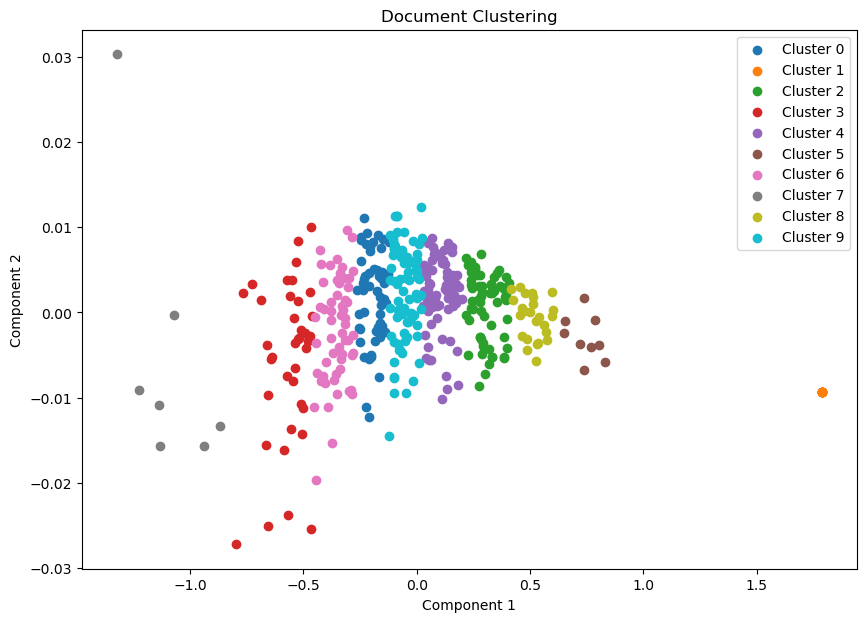

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Scaricare le risorse di NLTK necessarie
nltk.download('punkt')
nltk.download('stopwords')

documents = tutti_i_dati['Testo'].to_list()

# Esempio di documenti
'''documents = [
    "Questo è il primo documento.",
    "Questo documento è il secondo documento.",
    "E questo è il terzo documento.",
    "Il quarto documento è qui."
]'''

# Pre-processamento: tokenizzazione, rimozione stopwords e punteggiatura
stop_words = set(stopwords.words('italian'))
def preprocess(document):
    tokens = word_tokenize(document.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# Allenamento del modello Word2Vec
model = Word2Vec(sentences=processed_docs, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Calcolare i document embeddings
def document_embedding(document, model):
    valid_words = [word for word in document if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

document_embeddings = np.array([document_embedding(doc, model) for doc in processed_docs])

# Applicare KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(document_embeddings)
labels = kmeans.labels_

# Riduzione della dimensionalità con PCA o TSNE
# Usare PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(document_embeddings)

# Alternativa: usare TSNE
# tsne = TSNE(n_components=2, random_state=0)
# reduced_embeddings = tsne.fit_transform(document_embeddings)

# Plotting
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    points = reduced_embeddings[labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

plt.title("Document Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

In [16]:
pd.set_option('display.max_rows', None)

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_term="manifestazione", topn=1000):
    results = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se "manifestazione" è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word == filter_term and score >= score_threshold:
                    results.append((word, similar_word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
filtered_similar_words = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_term="manifestazione", topn=1000)

# Creare un DataFrame dai risultati filtrati
df = pd.DataFrame(filtered_similar_words, columns=["Parola Chiave", "Simile a", "Punteggio"])

df

Parola 'casal di principe' non presente nel modello.
Parola 'castelnuovo del garda' non presente nel modello.
Parola 'reggio nell'emilia' non presente nel modello.
Parola 'petralia soprana' non presente nel modello.
Parola 'cascina' non presente nel modello.
Parola 'bastia umbra' non presente nel modello.
Parola 'concordia sagittaria' non presente nel modello.
Parola 'san giovanni in persiceto' non presente nel modello.
Parola 'maratea' non presente nel modello.
Parola 'villa literno' non presente nel modello.
Parola 'riva del garda' non presente nel modello.
Parola 'francavilla al mare' non presente nel modello.
Parola 'san vito' non presente nel modello.
Parola 'calolziocorte' non presente nel modello.
Parola 'sala comacina' non presente nel modello.
Parola 'lercara friddi' non presente nel modello.
Parola 'predaia' non presente nel modello.
Parola 'pontecagnano faiano' non presente nel modello.
Parola 'attimis' non presente nel modello.
Parola 'muro leccese' non presente nel modello

Parola Chiave        Simile a  Punteggio
0           terni  manifestazione   0.911438
1          napoli  manifestazione   0.995990
2             ora  manifestazione   0.999609
3        piacenza  manifestazione   0.995498
4           ponte  manifestazione   0.994800
5          rovigo  manifestazione   0.901226
6              re  manifestazione   0.987225
7      valmontone  manifestazione   0.988543
8       tarquinia  manifestazione   0.984217
9            pisa  manifestazione   0.986315
10      catanzaro  manifestazione   0.957727
11        cassino  manifestazione   0.968335
12         verona  manifestazione   0.993745
13         rimini  manifestazione   0.994048
14        sanremo  manifestazione   0.998362
15         cesena  manifestazione   0.996548
16       barletta  manifestazione   0.915574
17          fondi  manifestazione   0.998803
18       casarano  manifestazione   0.958908
19          rieti  manifestazione   0.984324
20    torchiarolo  manifestazione   0.960298
21          lecce  manifestazione   0.995469
22      ferentino  manifestazione   0.932318
23     pontecorvo  manifestazione   0.939170
24        milazzo  manifestazione   0.964500
25       lanciano  manifestazione   0.990970
26        salento  manifestazione   0.966589
27          udine  manifestazione   0.992816
28        taranto  manifestazione   0.964167
29           anzi  manifestazione   0.995207
30      cerignola  manifestazione   0.913317
31         capaci  manifestazione   0.957538
32      melegnano  manifestazione   0.992276
33        colorno  manifestazione   0.993048
34          menfi  manifestazione   0.968130
35       avellino  manifestazione   0.994945
36          pavia  manifestazione   0.965004
37           zone  manifestazione   0.999420
38   forlimpopoli  manifestazione   0.968759
39         chieti  manifestazione   0.980508
40      conselice  manifestazione   0.914674
41        tornata  manifestazione   0.954238
42          capua  manifestazione   0.997065
43      agrigento  manifestazione   0.959910
44        viterbo  manifestazione   0.998417
45        rosarno  manifestazione   0.993157
46        salerno  manifestazione   0.987235
47         licata  manifestazione   0.968792
48          opera  manifestazione   0.993112
49         latina  manifestazione   0.986611
50      bertinoro  manifestazione   0.980298
51         arezzo  manifestazione   0.994817
52        venezia  manifestazione   0.994009
53        argenta  manifestazione   0.945491
54    premilcuore  manifestazione   0.979877
55       formello  manifestazione   0.983548
56        lomazzo  manifestazione   0.901528
57     conegliano  manifestazione   0.936571
58           naro  manifestazione   0.913148
59           lago  manifestazione   0.991483
60          paola  manifestazione   0.967578
61         fasano  manifestazione   0.910766
62        treviso  manifestazione   0.995399
63         lucera  manifestazione   0.958825
64        colonna  manifestazione   0.977759
65           roma  manifestazione   0.999827
66        sciacca  manifestazione   0.973902
67   montesilvano  manifestazione   0.916250
68         milano  manifestazione   0.997807
69      vescovana  manifestazione   0.910943
70      frosinone  manifestazione   0.963737
71        ruffano  manifestazione   0.990080
72         padova  manifestazione   0.998083
73         altare  manifestazione   0.984982
74       grosseto  manifestazione   0.920764
75           bari  manifestazione   0.998111
76          surbo  manifestazione   0.912378
77          prato  manifestazione   0.973692
78       montiano  manifestazione   0.979071
79        ravenna  manifestazione   0.995277
80        ferrara  manifestazione   0.997156
81         aversa  manifestazione   0.975803
82          siena  manifestazione   0.961592
83       campagna  manifestazione   0.998577
84         modena  manifestazione   0.998071
85          troia  manifestazione   0.985173
86        fidenza  manifestazione   0.901235
87         faenza  manifestazione   0.967745

In [17]:
import pandas as pd

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" e "corteo" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000):
    results_raduno = []
    results_manifestazione = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se una delle parole filtro è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word in filter_terms and score >= score_threshold:
                    if similar_word == "corteo":
                        results_raduno.append((word, score))
                    elif similar_word == "manifestazione":
                        results_manifestazione.append((word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results_raduno, results_manifestazione

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
results_corteo, results_manifestazione = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000)

# Creare un DataFrame dai risultati filtrati
df_corteo = pd.DataFrame(results_corteo, columns=["Parola Chiave", "Punteggio per Corteo"])
df_manifestazione = pd.DataFrame(results_manifestazione, columns=["Parola Chiave", "Punteggio per Manifestazione"])

# Unire i due DataFrame basati sulla colonna "Parola Chiave"
df = pd.merge(df_corteo, df_manifestazione, on="Parola Chiave", how="outer")

df

Parola 'casal di principe' non presente nel modello.
Parola 'castelnuovo del garda' non presente nel modello.
Parola 'reggio nell'emilia' non presente nel modello.
Parola 'petralia soprana' non presente nel modello.
Parola 'cascina' non presente nel modello.
Parola 'bastia umbra' non presente nel modello.
Parola 'concordia sagittaria' non presente nel modello.
Parola 'san giovanni in persiceto' non presente nel modello.
Parola 'maratea' non presente nel modello.
Parola 'villa literno' non presente nel modello.
Parola 'riva del garda' non presente nel modello.
Parola 'francavilla al mare' non presente nel modello.
Parola 'san vito' non presente nel modello.
Parola 'calolziocorte' non presente nel modello.
Parola 'sala comacina' non presente nel modello.
Parola 'lercara friddi' non presente nel modello.
Parola 'predaia' non presente nel modello.
Parola 'pontecagnano faiano' non presente nel modello.
Parola 'attimis' non presente nel modello.
Parola 'muro leccese' non presente nel modello

Parola Chiave  Punteggio per Corteo  Punteggio per Manifestazione
0           terni              0.910593                      0.911438
1          napoli              0.995597                      0.995990
2             ora              0.999407                      0.999609
3        piacenza              0.995238                      0.995498
4           ponte              0.994946                      0.994800
5          rovigo              0.900212                      0.901226
6              re              0.986207                      0.987225
7      valmontone              0.988487                      0.988543
8       tarquinia              0.983734                      0.984217
9            pisa              0.986420                      0.986315
10      catanzaro              0.958412                      0.957727
11        cassino              0.969197                      0.968335
12         verona              0.993826                      0.993745
13         rimini              0.994016                      0.994048
14        sanremo              0.998250                      0.998362
15         cesena              0.996086                      0.996548
16       barletta              0.913926                      0.915574
17          fondi              0.998779                      0.998803
18       casarano              0.958297                      0.958908
19          rieti              0.984375                      0.984324
20    torchiarolo              0.961189                      0.960298
21          lecce              0.995341                      0.995469
22      ferentino              0.930074                      0.932318
23     pontecorvo              0.939503                      0.939170
24        milazzo              0.964612                      0.964500
25       lanciano              0.990221                      0.990970
26        salento              0.967609                      0.966589
27          udine              0.992587                      0.992816
28        taranto              0.963281                      0.964167
29           anzi              0.994849                      0.995207
30      cerignola              0.912238                      0.913317
31         capaci              0.957604                      0.957538
32      melegnano              0.992082                      0.992276
33        colorno              0.992609                      0.993048
34          menfi              0.968090                      0.968130
35       avellino              0.994502                      0.994945
36          pavia              0.964415                      0.965004
37           zone              0.999110                      0.999420
38   forlimpopoli              0.969406                      0.968759
39         chieti              0.980085                      0.980508
40      conselice              0.914692                      0.914674
41        tornata              0.954950                      0.954238
42          capua              0.996951                      0.997065
43      agrigento              0.961091                      0.959910
44        viterbo              0.998167                      0.998417
45        rosarno              0.993059                      0.993157
46        salerno              0.987021                      0.987235
47         licata              0.969416                      0.968792
48          opera              0.993013                      0.993112
49         latina              0.986433                      0.986611
50      bertinoro              0.979890                      0.980298
51         arezzo              0.994566                      0.994817
52        venezia              0.993543                      0.994009
53        argenta              0.944439                      0.945491
54    premilcuore              0.979513                      0.979877
55       formello              0.982829                      0.983548
56        loma

In [18]:
intersezione = df['Parola Chiave'].to_list()
intersezione

['terni',
 'napoli',
 'ora',
 'piacenza',
 'ponte',
 'rovigo',
 're',
 'valmontone',
 'tarquinia',
 'pisa',
 'catanzaro',
 'cassino',
 'verona',
 'rimini',
 'sanremo',
 'cesena',
 'barletta',
 'fondi',
 'casarano',
 'rieti',
 'torchiarolo',
 'lecce',
 'ferentino',
 'pontecorvo',
 'milazzo',
 'lanciano',
 'salento',
 'udine',
 'taranto',
 'anzi',
 'cerignola',
 'capaci',
 'melegnano',
 'colorno',
 'menfi',
 'avellino',
 'pavia',
 'zone',
 'forlimpopoli',
 'chieti',
 'conselice',
 'tornata',
 'capua',
 'agrigento',
 'viterbo',
 'rosarno',
 'salerno',
 'licata',
 'opera',
 'latina',
 'bertinoro',
 'arezzo',
 'venezia',
 'argenta',
 'premilcuore',
 'formello',
 'lomazzo',
 'conegliano',
 'naro',
 'lago',
 'paola',
 'fasano',
 'treviso',
 'lucera',
 'colonna',
 'roma',
 'sciacca',
 'montesilvano',
 'milano',
 'vescovana',
 'frosinone',
 'ruffano',
 'padova',
 'altare',
 'grosseto',
 'bari',
 'surbo',
 'prato',
 'montiano',
 'ravenna',
 'ferrara',
 'aversa',
 'siena',
 'campagna',
 'modena',

In [19]:
it = pd.read_csv('IT.txt', sep='\t', header=None)

In [20]:
it = it.rename(columns={1: 'droppare', 2: 'Comune', 3: 'Regione', 4: 'codice_regione', 9: 'Lat', 10: 'Long'})
it = it.drop(columns=['droppare'])
it_filtrato = it[['Comune', 'Regione', 'codice_regione', 'Lat', 'Long']]
#it_filtrato

In [21]:
it_distinct = it_filtrato.drop_duplicates()
it_distinct["Comune"] = it_distinct["Comune"].str.lower()
#it_distinct

In [22]:
intersezione_df = pd.DataFrame(intersezione, columns=['Comune'])
#intersezione_df

In [23]:
df_inner = pd.merge(it_distinct, intersezione_df, on='Comune', how='inner')
#df_inner

In [24]:
import altair as alt

urlGeo='https://raw.githubusercontent.com/openpolis/geojson-italy/master/topojson/limits_IT_all.topo.json'
italyGeoRegions=alt.topo_feature(urlGeo,'regions')

italyBaseMap=alt.Chart(italyGeoRegions).mark_geoshape(
    fill='lightgray', stroke='black', strokeWidth=1
)

italyBaseMap

alt.Chart(...)

alt.LayerChart(...)
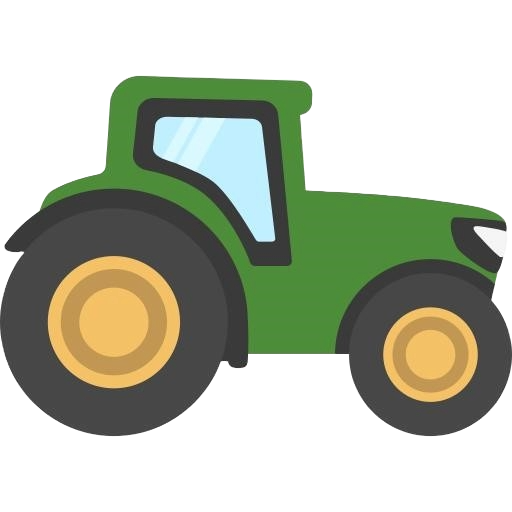

In [26]:
import altair as alt
import pandas as pd
import base64
from io import BytesIO
from PIL import Image

# Funzione per convertire l'immagine in una stringa base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Converti l'immagine locale in base64
image_path = "file.png"
base64_image = image_to_base64(image_path)
image_url = f"data:image/png;base64,{base64_image}"

bubbles=alt.Chart(df_inner).mark_image(
    url=image_url,
    width=20,
    height=20
).encode(
        latitude='Lat:Q',
        longitude='Long:Q',
        tooltip='Comune:N'
        #size='superficie totale - ettari:Q' # come fare i pallini più grandi (hint: cerco range nella documentazione)

    )

(italyBaseMap + bubbles).properties(width=600,height=600)

In [110]:
import altair as alt
import pandas as pd
import geopandas as gpd
import json

# Caricare i dati GeoJSON delle regioni italiane
url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson'
gdf = gpd.read_file(url)

# Assicurarsi che le regioni corrispondano ai dati (puoi adattare questi nomi)
data = {
    'Region': [
        'Piemonte', "Valle d'Aosta", 'Lombardia', 'Trentino-Alto Adige', 'Veneto', 'Friuli Venezia Giulia',
        'Liguria', 'Emilia-Romagna', 'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise',
        'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia', 'Sardegna'
    ],
    'Value': [10, 5, 20, 8, 30, 7, 15, 40, 50, 10, 20, 35, 5, 3, 25, 45, 5, 10, 30, 20]
}

df = pd.DataFrame(data)

# Assicurarsi che i nomi delle regioni nel GeoJSON corrispondano ai dati del DataFrame
gdf['Region'] = gdf['reg_name']

# Conversione in JSON
gdf_json = json.loads(gdf.to_json())

# Definire la selezione interattiva per la mappa
selection = alt.selection_single(fields=['properties.Region'], empty='none')

# Mappa delle regioni italiane
map_chart = alt.Chart(alt.Data(values=gdf_json['features'])).mark_geoshape().encode(
    tooltip=['properties.Region:N'],
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
).add_selection(
    selection
).project(
    'mercator'
).properties(
    width=500,
    height=600
)

# Bar plot dei valori per le regioni selezionate
bar_chart = alt.Chart(df).mark_bar().encode(
    x='Region:N',
    y='Value:Q',
    color=alt.condition(selection, alt.value("steelblue"), alt.value("lightgray"))
).properties(
    width=500,
    height=300
)

# Visualizzare i grafici insieme
combined_chart = map_chart | bar_chart
combined_chart

alt.HConcatChart(...)

In [106]:
import altair as alt
import pandas as pd
import geopandas as gpd
import json

# Caricare i dati GeoJSON delle regioni italiane
url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson'
gdf = gpd.read_file(url)

# Assicurarsi che le regioni corrispondano ai dati (puoi adattare questi nomi)
data = {
    'Region': [
        'Piemonte', "Valle d'Aosta", 'Lombardia', 'Trentino-Alto Adige', 'Veneto', 'Friuli Venezia Giulia',
        'Liguria', 'Emilia-Romagna', 'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise',
        'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia', 'Sardegna'
    ],
    'Value': [10, 5, 20, 8, 30, 7, 15, 40, 50, 10, 20, 35, 5, 3, 25, 45, 5, 10, 30, 20]
}

df = pd.DataFrame(data)

# Assicurarsi che i nomi delle regioni nel GeoJSON corrispondano ai dati del DataFrame
gdf['Region'] = gdf['reg_name']

# Conversione in JSON
gdf_json = json.loads(gdf.to_json())

# Definire la selezione interattiva per entrambi i grafici
selection = alt.selection_single(fields=['properties.reg_name'])

# Mappa delle regioni italiane
map_chart = alt.Chart(alt.Data(values=gdf_json['features'])).mark_geoshape().encode(
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray')),
    tooltip=['properties.reg_name:N']
).add_selection(
    selection
).project(
    'mercator'
).properties(
    width=500,
    height=600
)

# Bar plot dei valori per le regioni
bar_chart = alt.Chart(df).mark_bar().encode(
    x='Region:N',
    y='Value:Q',
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
).properties(
    width=500,
    height=300
)

# Visualizzare i grafici insieme
combined_chart = map_chart | bar_chart
combined_chart

alt.HConcatChart(...)

In [30]:
# Conta le occorrenze distinte nella colonna 'A' e trasforma il risultato in un DataFrame
df_count = df_inner['Regione'].value_counts().reset_index()

# Rinomina le colonne del nuovo DataFrame
df_count.columns = ['Regione', 'Conteggio']
df_count['Regione'] = df_count['Regione'].replace(['Abruzzi'],['Abruzzo'])
df_count

Regione  Conteggio
0          Emilia-Romagna         23
1                  Puglia         17
2                Campania         16
3               Lombardia         15
4                   Lazio         14
5                 Toscana          9
6                  Veneto          9
7                 Sicilia          8
8                 Abruzzo          7
9                Calabria          6
10               Piemonte          3
11    Trentino-Alto Adige          3
12                 Umbria          3
13                Liguria          2
14                 Marche          2
15  Friuli-Venezia Giulia          2
16             Basilicata          1
17                 Molise          1

In [1]:
import pandas as pd
import requests

# Lista delle regioni italiane
regioni_italiane = [
    'Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
    'Friuli-Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
    'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana',
    'Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta', 'Veneto'
]

# Funzione per ottenere le coordinate geografiche utilizzando un servizio di geocodifica (es. Nominatim di OpenStreetMap)
def ottieni_coordinate(regione):
    url = f"https://nominatim.openstreetmap.org/search.php?q={regione}, Italy&format=json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return {'Regione': regione, 'lat': lat, 'long': lon}
    return None

# Creazione del DataFrame delle coordinate geografiche delle regioni italiane
coordinate_regioni = [ottieni_coordinate(regione) for regione in regioni_italiane]
coordinate_df = pd.DataFrame(coordinate_regioni)

# Visualizza il DataFrame
coordinate_df

Regione         lat        long
0                 Abruzzo   42.227681   13.854983
1              Basilicata   40.500571   16.081953
2                Calabria  39.0565974  16.5249864
3                Campania   40.860672   14.843984
4          Emilia-Romagna   44.525696   11.039437
5   Friuli-Venezia Giulia   46.151042   13.055904
6                   Lazio  41.9808038  12.7662312
7                 Liguria  44.4777617   8.7026296
8               Lombardia  45.5703694   9.7732524
9                  Marche  43.3458388  13.1415872
10                 Molise   41.684672   14.595614
11               Piemonte   45.060735    7.923549
12                 Puglia  40.9842539  16.6210027
13               Sardegna  40.0912813   9.0305773
14                Sicilia   37.587794   14.155048
15                Toscana  43.4586541  11.1389204
16    Trentino-Alto Adige   46.441472   11.282121
17                 Umbria   42.965916   12.490236
18          Valle d'Aosta   45.730099    7.387426
19                 Veneto  45.6476663  11.8665254

In [32]:
import pandas as pd
import altair as alt

# Creazione di un DataFrame di esempio con i codici ISTAT delle regioni italiane
dati = {
    'Regione': ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli-Venezia Giulia',
                'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna',
                'Sicilia', 'Toscana', 'Trentino-Alto Adige', 'Umbria', "Valle d'Aosta", 'Veneto'],
    'codice_regione': [13, 17, 18, 15, 8, 6, 12, 7, 3, 11, 14, 1, 16, 20, 19, 9, 4, 10, 2, 5]
}

df_codice_regione = pd.DataFrame(dati)
df_codice_regione

Regione  codice_regione
0                 Abruzzo              13
1              Basilicata              17
2                Calabria              18
3                Campania              15
4          Emilia-Romagna               8
5   Friuli-Venezia Giulia               6
6                   Lazio              12
7                 Liguria               7
8               Lombardia               3
9                  Marche              11
10                 Molise              14
11               Piemonte               1
12                 Puglia              16
13               Sardegna              20
14                Sicilia              19
15                Toscana               9
16    Trentino-Alto Adige               4
17                 Umbria              10
18          Valle d'Aosta               2
19                 Veneto               5

In [67]:
df_final = df_count.merge(coordinate_df, on='Regione', how='right')
df_final_2 = df_final.merge(df_codice_regione, on='Regione', how='inner')
df_final_2

Regione  Conteggio         lat        long  codice_regione
0                 Abruzzo        7.0   42.227681   13.854983              13
1              Basilicata        1.0   40.500571   16.081953              17
2                Calabria        6.0  39.0565974  16.5249864              18
3                Campania       16.0   40.860672   14.843984              15
4          Emilia-Romagna       23.0   44.525696   11.039437               8
5   Friuli-Venezia Giulia        2.0   46.151042   13.055904               6
6                   Lazio       14.0  41.9808038  12.7662312              12
7                 Liguria        2.0  44.4777617   8.7026296               7
8               Lombardia       14.0  45.5703694   9.7732524               3
9                  Marche        1.0  43.3458388  13.1415872              11
10                 Molise        NaN   41.684672   14.595614              14
11               Piemonte        3.0   45.060735    7.923549               1
12                 Puglia       17.0  40.9842539  16.6210027              16
13               Sardegna        NaN  40.0912813   9.0305773              20
14                Sicilia       10.0   37.587794   14.155048              19
15                Toscana        9.0  43.4586541  11.1389204               9
16    Trentino-Alto Adige        3.0   46.441472   11.282121               4
17                 Umbria        3.0   42.965916   12.490236              10
18          Valle d'Aosta        NaN   45.730099    7.387426               2
19                 Veneto        6.0  45.6476663  11.8665254               5

In [68]:
df_final_2["Conteggio"].fillna(0, inplace=True)
df_final_2

Regione  Conteggio         lat        long  codice_regione
0                 Abruzzo        7.0   42.227681   13.854983              13
1              Basilicata        1.0   40.500571   16.081953              17
2                Calabria        6.0  39.0565974  16.5249864              18
3                Campania       16.0   40.860672   14.843984              15
4          Emilia-Romagna       23.0   44.525696   11.039437               8
5   Friuli-Venezia Giulia        2.0   46.151042   13.055904               6
6                   Lazio       14.0  41.9808038  12.7662312              12
7                 Liguria        2.0  44.4777617   8.7026296               7
8               Lombardia       14.0  45.5703694   9.7732524               3
9                  Marche        1.0  43.3458388  13.1415872              11
10                 Molise        0.0   41.684672   14.595614              14
11               Piemonte        3.0   45.060735    7.923549               1
12                 Puglia       17.0  40.9842539  16.6210027              16
13               Sardegna        0.0  40.0912813   9.0305773              20
14                Sicilia       10.0   37.587794   14.155048              19
15                Toscana        9.0  43.4586541  11.1389204               9
16    Trentino-Alto Adige        3.0   46.441472   11.282121               4
17                 Umbria        3.0   42.965916   12.490236              10
18          Valle d'Aosta        0.0   45.730099    7.387426               2
19                 Veneto        6.0  45.6476663  11.8665254               5

In [65]:
apiCovid='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
df=pd.read_csv(apiCovid, parse_dates=['data'])[['denominazione_regione', 'codice_regione', 'lat', 'long']].drop_duplicates()
df

denominazione_regione  codice_regione        lat       long
0                   Abruzzo              13  42.351222  13.398438
1                Basilicata              17  40.639471  15.805148
2                  Calabria              18  38.905976  16.594402
3                  Campania              15  40.839566  14.250850
4            Emilia-Romagna               8  44.494367  11.341721
5     Friuli Venezia Giulia               6  45.649435  13.768136
6                     Lazio              12  41.892770  12.483667
7                   Liguria               7  44.411493   8.932699
8                 Lombardia               3  45.466794   9.190347
9                    Marche              11  43.616760  13.518875
10                   Molise              14  41.557748  14.659161
11             P.A. Bolzano              21  46.499335  11.356624
12              P.A. Trento              22  46.068935  11.121231
13                 Piemonte               1  45.073274   7.680687
14                   Puglia              16  41.125596  16.867367
15                 Sardegna              20  39.215312   9.110616
16                  Sicilia              19  38.115697  13.362357
17                  Toscana               9  43.769231  11.255889
18                   Umbria              10  43.106758  12.388247
19            Valle d'Aosta               2  45.737503   7.320149
20                   Veneto               5  45.434905  12.338452
2578                Sicilia              19  38.115697  13.362357

In [217]:
df_final = df.merge(df_count, on='denominazione_regione', how='inner')
df_final

denominazione_regione  codice_regione        lat       long  Conteggio
0                Abruzzo              13  42.351222  13.398438         21
1             Basilicata              17  40.639471  15.805148          3
2               Calabria              18  38.905976  16.594402         15
3               Campania              15  40.839566  14.250850         49
4         Emilia-Romagna               8  44.494367  11.341721         62
5                  Lazio              12  41.892770  12.483667         35
6                Liguria               7  44.411493   8.932699         10
7              Lombardia               3  45.466794   9.190347         49
8                 Marche              11  43.616760  13.518875         24
9                 Molise              14  41.557748  14.659161          3
10              Piemonte               1  45.073274   7.680687         11
11                Puglia              16  41.125596  16.867367         48
12              Sardegna              20  39.215312   9.110616          3
13               Sicilia              19  38.115697  13.362357         38
14               Sicilia              19  38.115697  13.362357         38
15               Toscana               9  43.769231  11.255889         18
16                Umbria              10  43.106758  12.388247          7
17                Veneto               5  45.434905  12.338452         25

In [69]:
alt.Chart(italyGeoRegions).mark_geoshape(
    stroke='#fff', strokeWidth=0.25
).transform_lookup(
    lookup='properties.reg_istat_code_num', from_=alt.LookupData(data=df_final_2, key='codice_regione', fields=['Regione', 'Conteggio'])
).encode(
    color= alt.Color('Conteggio:Q', scale=alt.Scale(scheme='oranges', type='quantize')),
    tooltip= [
              alt.Tooltip('Conteggio:Q'),
              alt.Tooltip('Regione:N')
              #alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=400,
    height=400
).configure_view(
    stroke=None
)

alt.Chart(...)